<a href="https://colab.research.google.com/github/suhaibkq/ComputerVisionUsingNeuralNetworks/blob/main/HelmNet_Low_Code_GH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 81.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/MyDrive/Colab Notebooks/M6 CV Workplace Safety Project/images_proj.npy') #Complete the code to load the images

labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/M6 CV Workplace Safety Project/Labels_proj.csv') #Complete the code to load the labels

In [ ]:
print(images.shape) #Complete the code to print the shape of the images
print(labels.shape) #Complete the code to print the shape of the labels

(631, 200, 200, 3)
(631, 1)


# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

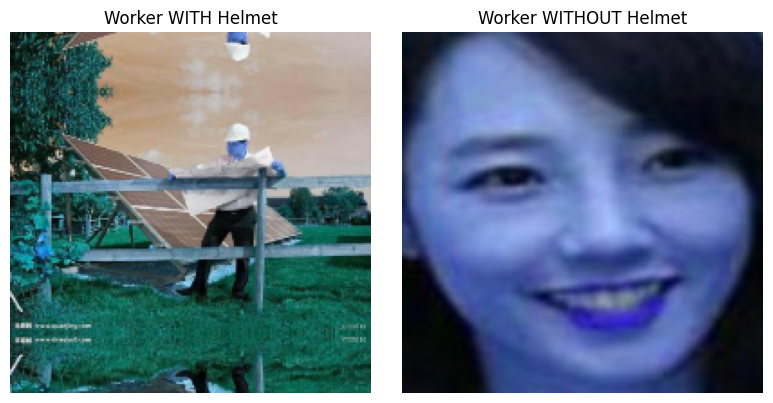

In [ ]:
helmet_indices = np.where(labels == 1)[0]
no_helmet_indices = np.where(labels == 0)[0]  #Complete the code to define an index (For example, 0,30,1,.etc)

# Select one image from each class
helmet_img = images[np.random.choice(helmet_indices)]
no_helmet_img = images[np.random.choice(no_helmet_indices)]

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display "With Helmet" image
axes[0].imshow(helmet_img)
axes[0].set_title("Worker WITH Helmet")
axes[0].axis('off')

# Display "Without Helmet" image
axes[1].imshow(no_helmet_img)
axes[1].set_title("Worker WITHOUT Helmet")
axes[1].axis('off')

# Show the plots
plt.tight_layout()
plt.show()

## Checking for class imbalance


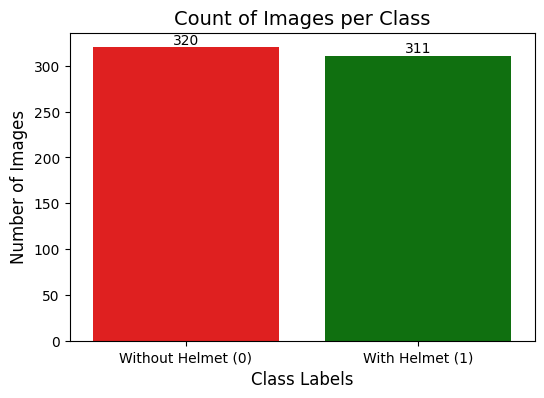

In [ ]:
# Create a count plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels.iloc[:, 0], palette=['red', 'green'])

# Add exact counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, )

# Add labels
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Count of Images per Class", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Without Helmet (0)", "With Helmet (1)"])  # Rename x-axis labels

# Show plot
plt.show()

# **Data Preprocessing**

## Converting images to grayscale

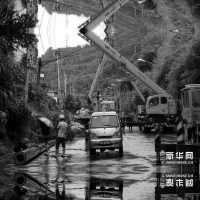

In [ ]:
images_gray = []
for i in range(len(images)):
    img_gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    images_gray.append(img_gray)

# Display a sample grayscale image
n = 0  #Complete the code to define an index value
cv2_imshow(images_gray[n])

### Splitting the dataset



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels) #Complete the code to define the test_size
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp) #Complete the code to define the test_size

In [ ]:
print(X_train.shape,y_train.shape) #Complete the code to print the shape of the train data
print(X_val.shape,y_val.shape) #Complete the code to print the shape of the validation data
print(X_test.shape,y_test.shape) #Complete the code to print the shape of the test data

(504, 200, 200, 3) (504, 1)
(63, 200, 200, 3) (63, 1)
(64, 200, 200, 3) (64, 1)


### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [ ]:
X_train_normalized = X_train.astype('float32')/255. #Complete the code to normalize the training images
X_val_normalized = X_val.astype('float32')/255.  #Complete the code to normalize the validation images
X_test_normalized = X_test.astype('float32')/255.   #Complete the code to normalize the test images

# **Model Building**

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

Let's build a **CNN Model**.<br>

The model has 2 main parts:
1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers for prediction.**<br><br>





In [ ]:
# Initializing Model
model_1 = Sequential()

# Convolutional layers
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200,200,3))) #Complete the code to define the shape of the input image
model_1.add(MaxPooling2D((4, 4), padding='same'))
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function
model_1.add(MaxPooling2D((2,2), padding='same')) #Complete the code to define the shape of the pooling kernel
model_1.add(Conv2D(128, (3,3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function

# Flatten and Dense layers
model_1.add(Flatten())
model_1.add(Dense(4, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))  #Complete the code to define the number of neurons in the output layer and the activation function

# Compile with Adam Optimizer
opt = Adam(learning_rate=0.001) #Complete the code to define the learning rate.
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy","Precision"]) #Complete the code to define the metric of choice from Precision,f1_score,Recall

# Summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       320,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,257 (1.58 MB)

 Trainable params: 413,257 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model_1.fit(
            X_train_normalized, y_train,
            epochs=10, #Complete the code to define the number of epochs
            validation_data=(X_val_normalized,y_val),
            shuffle=True,
            batch_size=32, #Complete the code to define the batch size
            verbose=2
)

Epoch 1/10
16/16 - 11s - 688ms/step - Precision: 0.6538 - accuracy: 0.7143 - loss: 0.6448 - val_Precision: 1.0000 - val_accuracy: 0.8889 - val_loss: 0.4747
Epoch 2/10
16/16 - 0s - 28ms/step - Precision: 0.9518 - accuracy: 0.9544 - loss: 0.2994 - val_Precision: 1.0000 - val_accuracy: 0.9524 - val_loss: 0.1681
Epoch 3/10
16/16 - 0s - 27ms/step - Precision: 0.9465 - accuracy: 0.9385 - loss: 0.2375 - val_Precision: 1.0000 - val_accuracy: 0.8095 - val_loss: 0.6367
Epoch 4/10
16/16 - 1s - 38ms/step - Precision: 0.9717 - accuracy: 0.9702 - loss: 0.1199 - val_Precision: 1.0000 - val_accuracy: 0.9683 - val_loss: 0.0643
Epoch 5/10
16/16 - 0s - 29ms/step - Precision: 0.9879 - accuracy: 0.9881 - loss: 0.0805 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 6/10
16/16 - 0s - 27ms/step - Precision: 0.9918 - accuracy: 0.9841 - loss: 0.0593 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 7/10
16/16 - 1s - 38ms/step - Precision: 0.9960 - accuracy: 0.9960 -

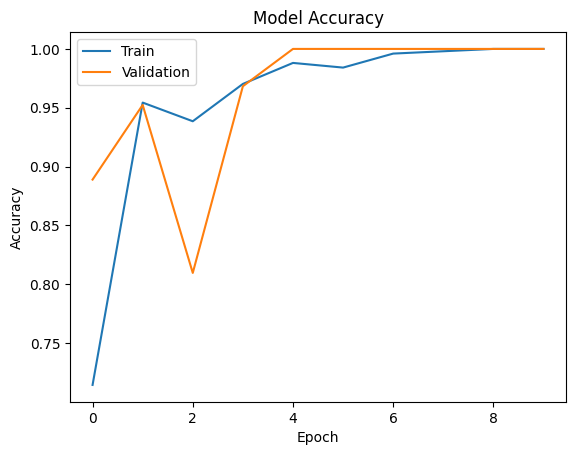

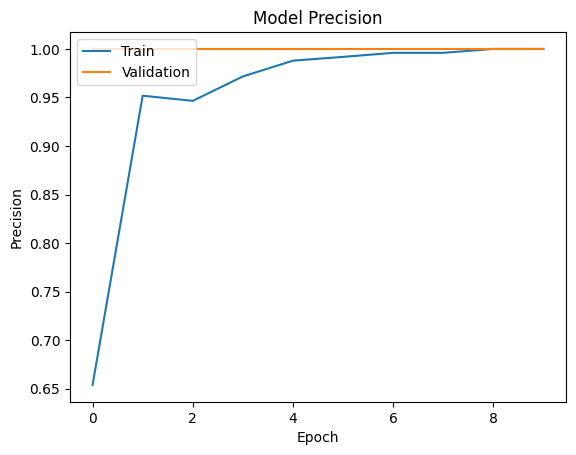

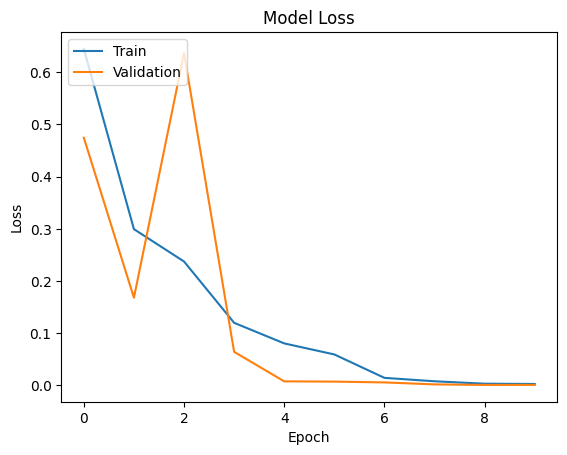

In [ ]:
plt.plot(history_1.history['accuracy']) #Complete the code to plot the train metrics
plt.plot(history_1.history['val_accuracy']) #Complete the code to plot the validation data metrics
plt.title('Model Accuracy') #Complete the code to define the title for the plot
plt.ylabel('Accuracy') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_1.history['Precision']) #Complete the code to plot the train metrics
plt.plot(history_1.history['val_Precision']) #Complete the code to plot the validation data metrics
plt.title('Model Precision') #Complete the code to define the title for the plot
plt.ylabel('Precision') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss']) #Complete the code to plot the train metrics
plt.plot(history_1.history['val_loss']) #Complete the code to plot the validation data metrics
plt.title('Model Loss') #Complete the code to define the title for the plot
plt.ylabel('Loss') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train)

print("Train performance metrics")
print(model_1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.998016  0.998016   0.998024  0.998016


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


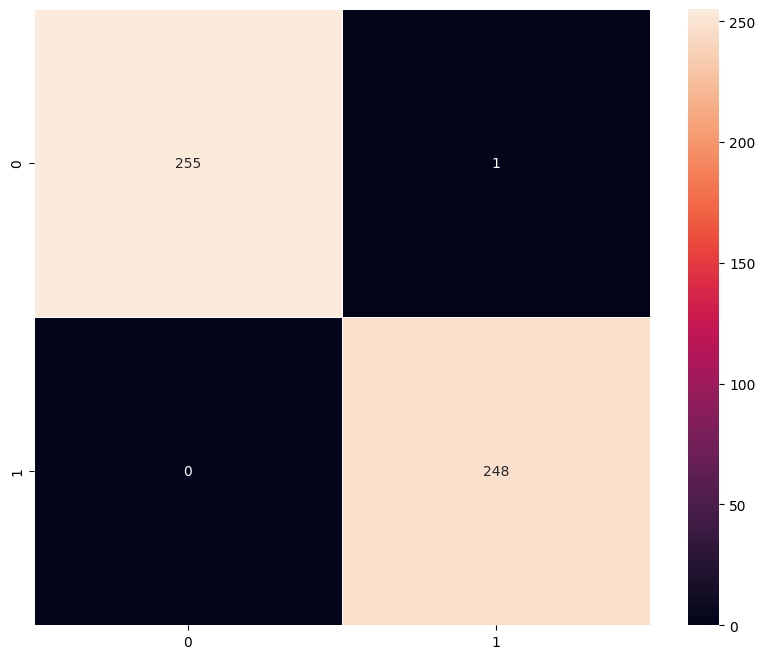

In [ ]:
plot_confusion_matrix(model_1,X_train_normalized,y_train)

In [ ]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_1_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


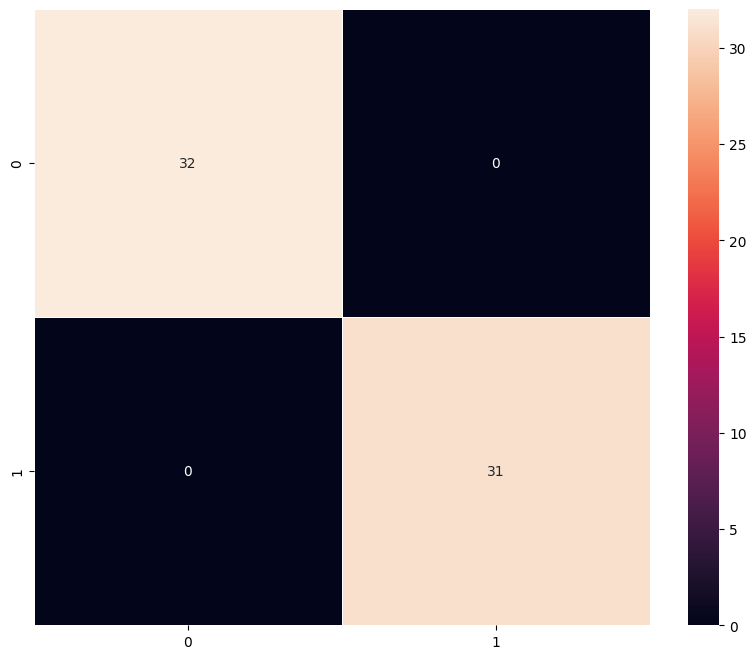

In [ ]:
plot_confusion_matrix(model_1,X_val_normalized,y_val)

### Vizualizing the predictions

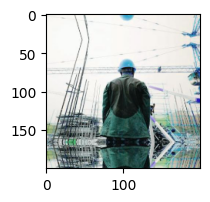

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Predicted Label: 0
True Label: Label    1
Name: 62, dtype: int64


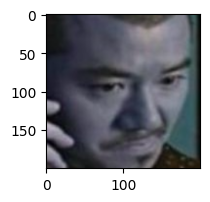

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [ ]:
# For index 2
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

## Model 2: (VGG-16 (Base))

- We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will add a Flatten and a single dense layer.


In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3)) #Complete the code to define the shape of the image
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid')) #Complete the code to define the number of neurons in the output layer.

In [ ]:
opt=Adam(learning_rate=0.001) #Complete the code to define the learning rate
# Compile model
model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy","Precision"]) #Complete the code to define the metrics

In [ ]:
# Generating the summary of the model
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator()

In [ ]:
# Epochs
epochs = 10 #Complete the code to define the epochs
# Batch size
batch_size = 32 #Complete the code to define the batch size

history_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train,
                                      batch_size=batch_size,
                                      seed=42,
                                      shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - Precision: 0.6859 - accuracy: 0.6953 - loss: 0.5185 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0401 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0208 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0105 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0039 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0039 - val_Precision: 1.0000 - val_accuracy:

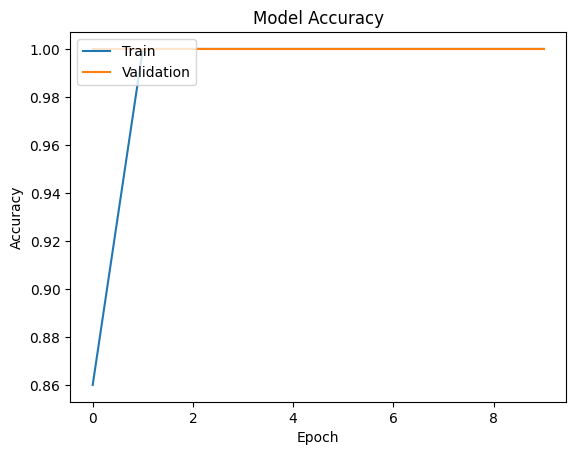

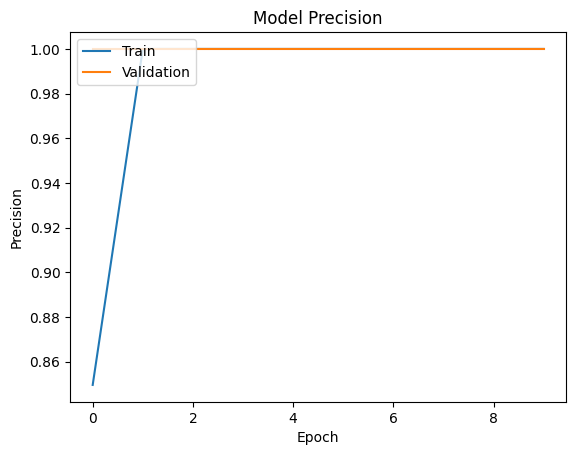

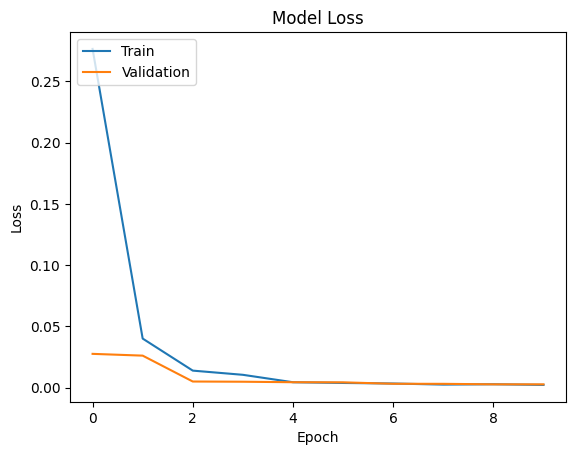

In [ ]:
plt.plot(history_2.history['accuracy']) #Complete the code to plot the train metrics
plt.plot(history_2.history['val_accuracy']) #Complete the code to plot the validation data metrics
plt.title('Model Accuracy') #Complete the code to define the title for the plot
plt.ylabel('Accuracy') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['Precision']) #Complete the code to plot the train metrics
plt.plot(history_2.history['val_Precision']) #Complete the code to plot the validation data metrics
plt.title('Model Precision') #Complete the code to define the title for the plot
plt.ylabel('Precision') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss']) #Complete the code to plot the train metrics
plt.plot(history_2.history['val_loss']) #Complete the code to define the validation data metrics
plt.title('Model Loss') #Complete the code to define the title for the plot
plt.ylabel('Loss') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2_train_perf = model_performance_classification(model_2,X_train_normalized,y_train)

print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step


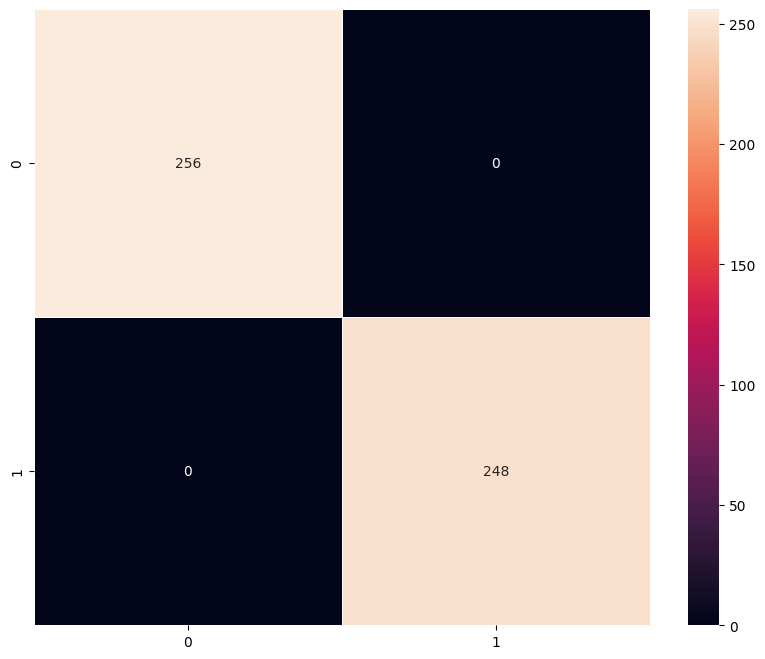

In [ ]:
plot_confusion_matrix(model_2,X_train_normalized,y_train)

In [ ]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_2_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


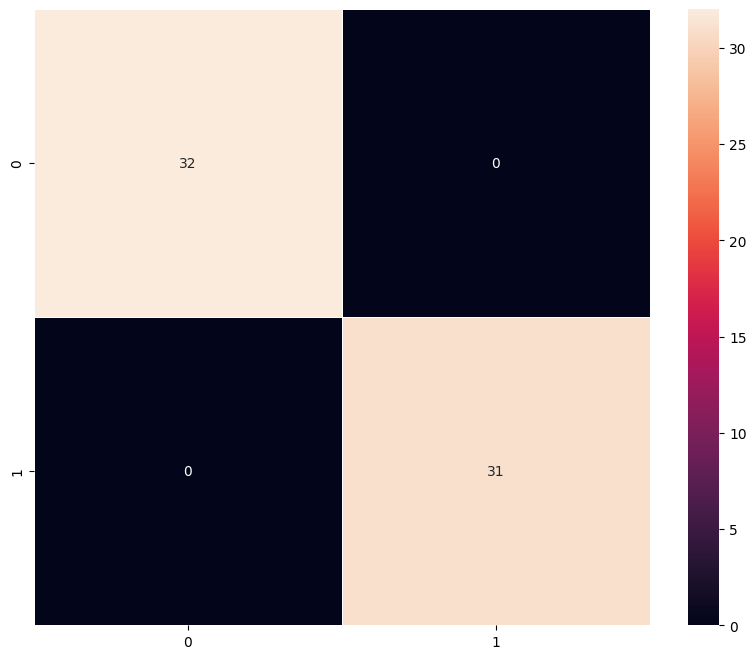

In [ ]:
plot_confusion_matrix(model_2,X_val_normalized,y_val)

### Visualizing the prediction:

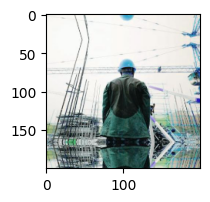

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: 1
True Label: Label    1
Name: 62, dtype: int64


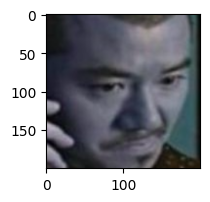

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[12]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[12].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12] #Complete the code to define the index
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[33]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[33].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33] #Complete the code to define the index
print('True Label:', true_label)

## Model 3: (VGG-16 (Base + FFNN))

- We will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will add a Flatten layer and a Feed Forward Neural Network.


In [ ]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(256,activation='relu')) #Complete the code to define the number of neurons and the activation function
model_3.add(Dropout(rate=0.5)) #Complete the code to define the dropout rate
model_3.add(Dense(128,activation='relu')) #Complete the code to define the number of neurons and the activation function

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid')) #Complete the code to define the number of neurons in the output layer and the activation function

In [ ]:
opt = Adam(learning_rate=0.001) #Complete the code to define the learning rate

In [ ]:
# Compile model
model_3.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "Precision"]) #Complete the code to define the metrics

In [ ]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32, #Complete the code to define the batch size
                                       seed=42,
                                       shuffle=False),
                    epochs=10, #Complete the code to define the number of epochs
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - Precision: 0.7879 - accuracy: 0.7751 - loss: 0.4530 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.8189e-05
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 3.2365e-05 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 7.2780e-06
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - Precision: 0.9927 - accuracy: 0.9961 - loss: 0.0255 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.8175e-04
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 1.3382e-04 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.1732e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - Precision: 1.0000 - accuracy: 0.9991 - loss: 7.8604e-04 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.1884e-07
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 5.1454e-05 

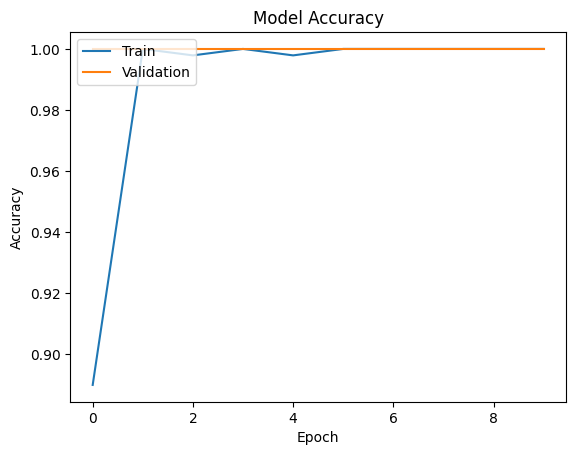

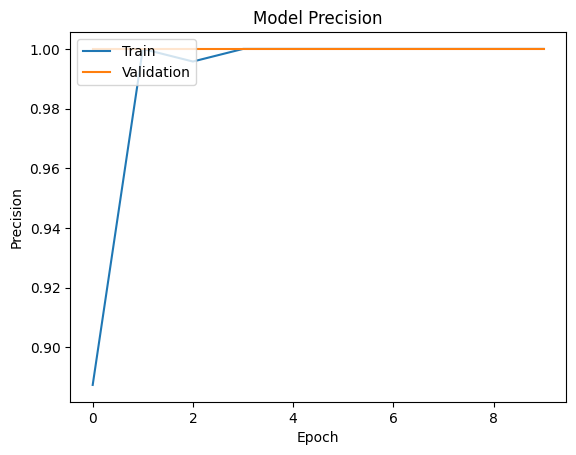

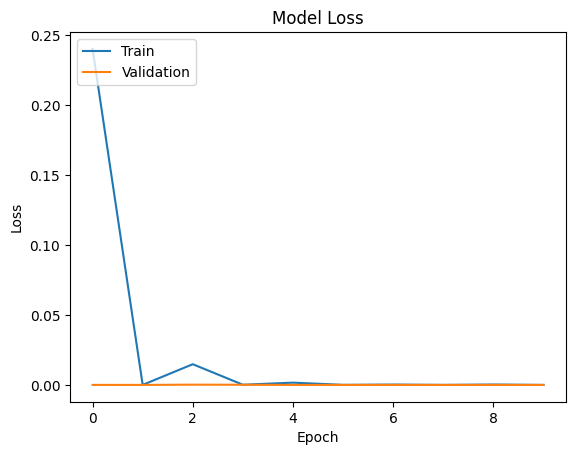

In [ ]:
plt.plot(history_3.history['accuracy']) #Complete the code to plot the train metrics
plt.plot(history_3.history['val_accuracy']) #Complete the code to plot the validation data metrics
plt.title('Model Accuracy') #Complete the code to define the title for the plot
plt.ylabel('Accuracy') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['Precision']) #Complete the code to plot the train metrics
plt.plot(history_3.history['val_Precision']) #Complete the code to plot the validation data metrics
plt.title('Model Precision') #Complete the code to define the title for the plot
plt.ylabel('Precision') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss']) #Complete the code to plot the train metrics
plt.plot(history_3.history['val_loss']) #Complete the code to define the validation data metrics
plt.title('Model Loss') #Complete the code to define the title for the plot
plt.ylabel('Loss') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train)

print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


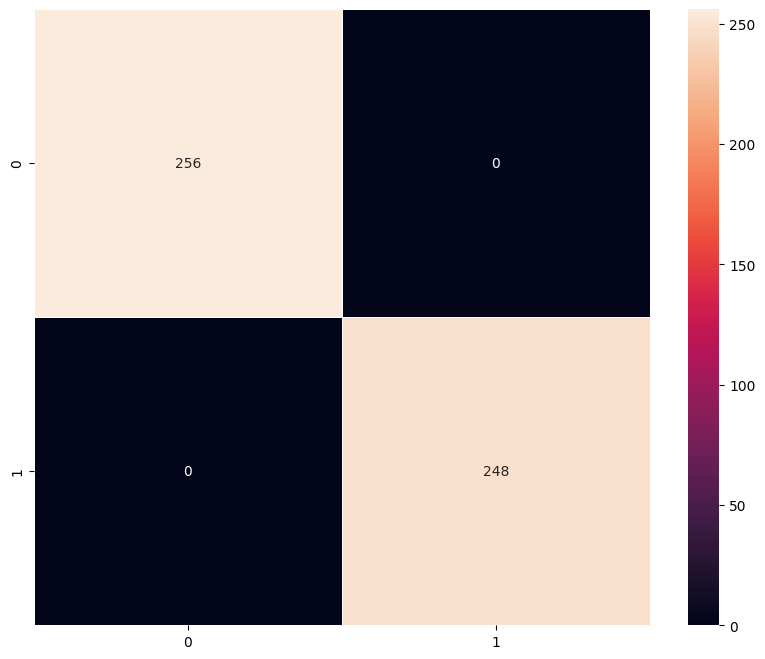

In [ ]:
plot_confusion_matrix(model_3,X_train_normalized,y_train)

In [ ]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_3_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


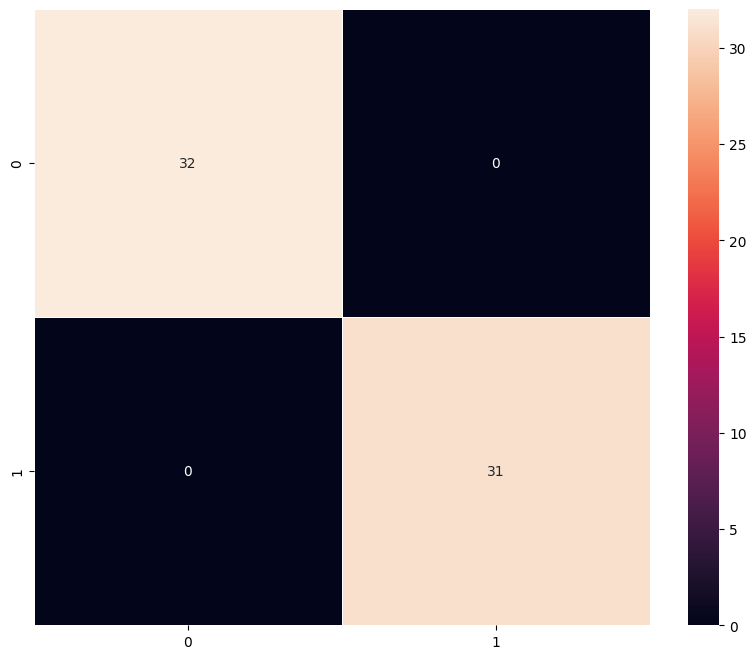

In [ ]:
plot_confusion_matrix(model_3,X_val_normalized,y_val)

#### Visualizing the predictions

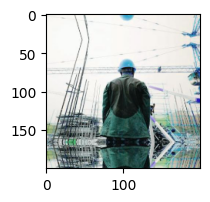

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Label: 1
True Label: Label    1
Name: 62, dtype: int64


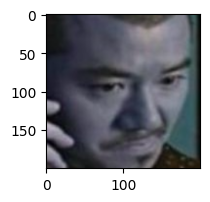

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[12]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[12].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12] #Complete the code to define the index
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[33]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[33].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33] #Complete the code to define the index
print('True Label:', true_label)

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(256,activation='relu')) #Complete the code to define the number of neurons and the activation function
model_4.add(Dropout(rate=0.5)) #Complete the code to define the dropout rate
model_4.add(Dense(128,activation='relu')) #Complete the code to define the number of neurons and the activation function

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid')) #Complete the code to define the number of neurons in the output layer and the actiavtion function

In [ ]:
opt=Adam(learning_rate=0.001)
# Compile model
model_4.compile(optimizer=opt,   loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "Precision"]) #Complete the code to define the metrics

In [ ]:
# Generating the summary of the model
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20, #Complete the code to define the range for rotation
                              fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.1
                              ) #Complete the code to define the parameters for the data augmentation

In [ ]:
history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32, #Complete the code to define the batch size
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - Precision: 0.6955 - accuracy: 0.6609 - loss: 0.8741 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0279
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0304 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0349
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - Precision: 0.9866 - accuracy: 0.9664 - loss: 0.1123 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.2591e-05
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Precision: 0.9412 - accuracy: 0.9688 - loss: 0.0372 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.4918e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - Precision: 0.9992 - accuracy: 0.9928 - loss: 0.0319 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.6278e-05
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 3.9600e-04 - val_Precision: 1.0

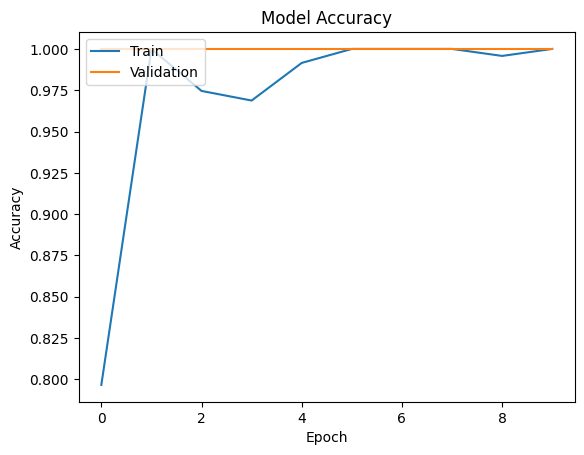

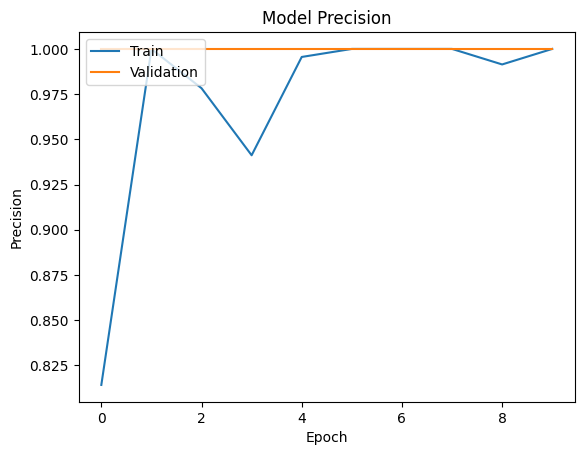

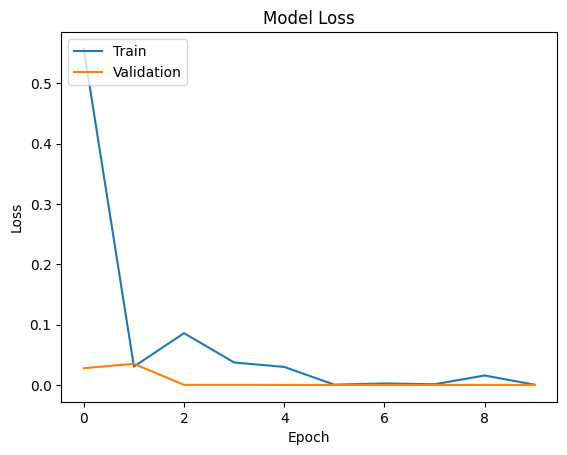

In [ ]:
plt.plot(history_4.history['accuracy']) #Complete the code to plot the train metrics
plt.plot(history_4.history['val_accuracy']) #Complete the code to plot the validation data metrics
plt.title('Model Accuracy') #Complete the code to define the title for the plot
plt.ylabel('Accuracy') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['Precision']) #Complete the code to plot the train metrics
plt.plot(history_4.history['val_Precision']) #Complete the code to plot the validation data metrics
plt.title('Model Precision') #Complete the code to define the title for the plot
plt.ylabel('Precision') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss']) #Complete the code to plot the train metrics
plt.plot(history_4.history['val_loss']) #Complete the code to define the validation data metrics
plt.title('Model Loss') #Complete the code to define the title for the plot
plt.ylabel('Loss') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized,y_train)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step


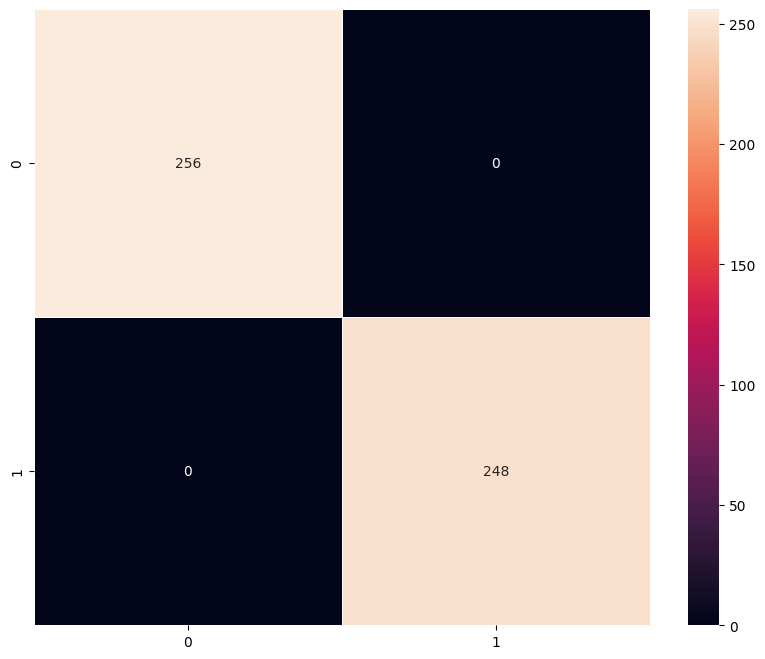

In [ ]:
plot_confusion_matrix(model_4,X_train_normalized,y_train)

In [ ]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_4_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


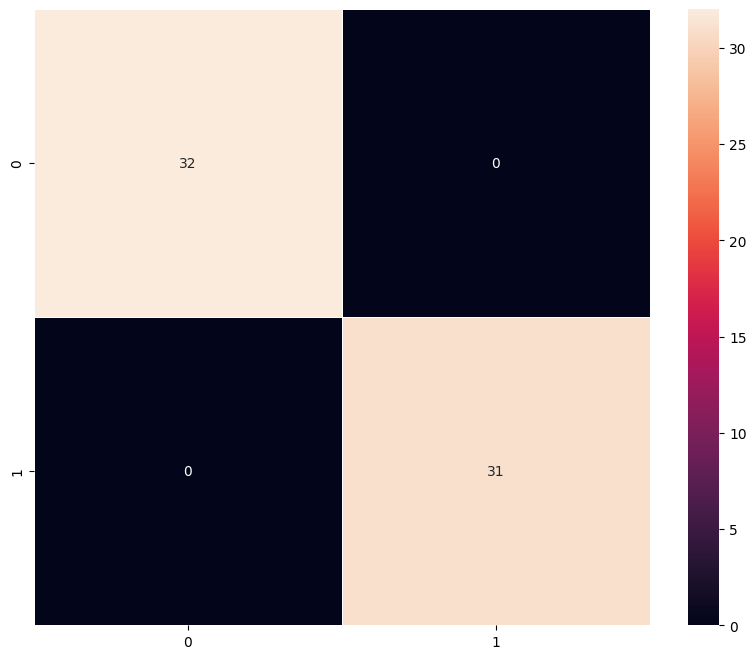

In [ ]:
plot_confusion_matrix(model_4,X_val_normalized,y_val)

#### Visualizing the predictions

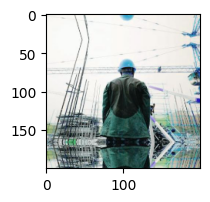

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label: 1
True Label: Label    1
Name: 62, dtype: int64


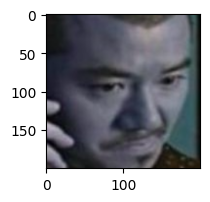

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[12]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[12].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12] #Complete the code to define the index
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[33]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[33].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33] #Complete the code to define the index
print('True Label:', true_label)

# **Model Performance Comparison and Final Model Selection**

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.998016,1.0,1.0,1.0
Recall,0.998016,1.0,1.0,1.0
Precision,0.998024,1.0,1.0,1.0
F1 Score,0.998016,1.0,1.0,1.0


In [ ]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [ ]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,-0.001984,0.0,0.0,0.0
Recall,-0.001984,0.0,0.0,0.0
Precision,-0.001976,0.0,0.0,0.0
F1 Score,-0.001984,0.0,0.0,0.0


## Test Performance

In [ ]:
model_test_perf = model_performance_classification(model_4, X_test_normalized,y_test) #Complete the code to pass the best model (Pass the variable corresponding to it. For example, model_1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [ ]:
model_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


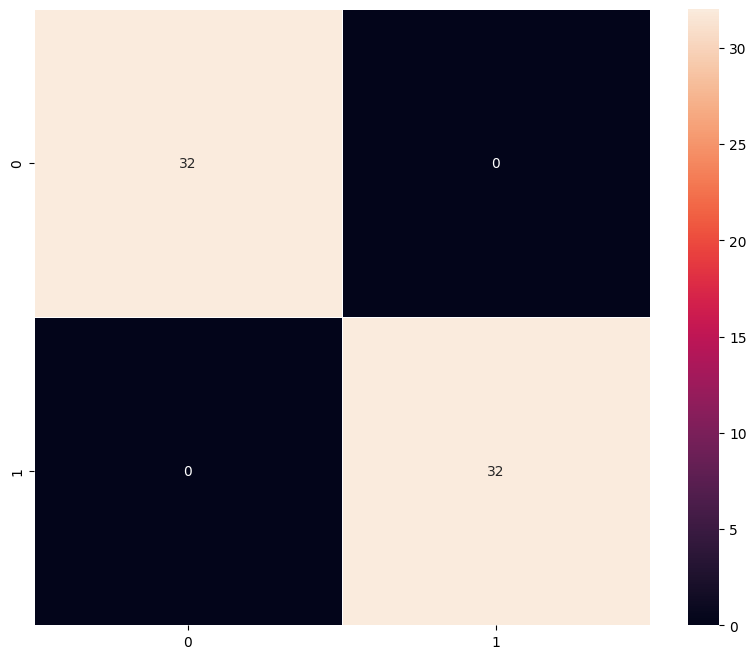

In [ ]:
plot_confusion_matrix(model_4, X_test_normalized,y_test) #Complete the code to pass the best model (Pass the variable corresponding to it. For example, model_1)